In [1]:
import glob
import torch
import copy
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
horizon = 60

In [1]:
class LoadData:
    def __init__(self):
        # load data and do seperate train and test set
        X_list = glob.glob("./AEData_32/ac_density_*.npy")
        Y_list = glob.glob("./AEData_32/ev_2class_density_*.npy")
        for idx in range(len(X_list)):
            if idx == 0:
                self.X = np.load(X_list[idx])[None, ...]
                self.Y = np.load(Y_list[idx])[None, ...]
            else:
                self.X = np.concatenate((self.X, np.load(X_list[idx])[None, ...]), axis=0)
                self.Y = np.concatenate((self.Y, np.load(Y_list[idx])[None, ...]), axis=0)
        #self.X, self.Y = self.X*100, self.Y*100
        self.Y = self.Y*100
    def dataloader(self, bs, ratio):
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=ratio, shuffle=True)
        X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
        Y_train, Y_test = torch.Tensor(Y_train), torch.Tensor(Y_test)

        trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=bs, shuffle=True, num_workers=0)
        testloader = DataLoader(TensorDataset(X_test, Y_test), batch_size=bs, shuffle=True, num_workers=0)
        return trainloader, testloader

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=5, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=7, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=5, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=4, stride=1, padding=1),
            #nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, nf):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(nf * 4, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(nf * 8, nf * 2, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nf * 2, nf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(nf * 2, 1, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(nf, 1, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.ReLU()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
batch_size = 1
test_ratio = 0.1

# load data
trainloader, testloader = LoadData().dataloader(batch_size, test_ratio)

In [6]:
nf = 8
net = AutoEncoder(nf)

if torch.cuda.is_available():
    GPU = 1
    print('Training on GPU')
    net = net.cuda()

Training on GPU


In [7]:
net

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTra

In [8]:
#init_weights = copy.deepcopy(net.decoder[2].weight.data)
init_weights = copy.deepcopy(net.decoder[3].weight.data)

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00001)
criterion = nn.MSELoss()

# Training

In [10]:
epochs = 5000

In [11]:
# training
trainloss = []
for epoch in range(epochs):
    training_loss = 0

    for X_train, Y_train in trainloader:
        X_train = X_train.view(-1, 1, X_train.shape[-2], X_train.shape[-1])
        Y_train = Y_train.view(-1, 1, Y_train.shape[-2], Y_train.shape[-1])

        if GPU:
            X_train, Y_train = Variable(X_train).cuda(), Variable(Y_train).cuda()

        optimizer.zero_grad()
        X_pred = net(X_train)
        loss = criterion(X_pred, Y_train)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() / X_train.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch + 1, epochs, training_loss))
    trainloss.append(training_loss)

np.save('Epochs_{}_Horizon_{}.npy'.format(epochs, horizon), np.asarray(trainloss))    

Epoch: 1/5000 	 Mean Square Error Loss: 1.0365940819183985
Epoch: 2/5000 	 Mean Square Error Loss: 1.0230209668477375
Epoch: 3/5000 	 Mean Square Error Loss: 1.0195671637852988
Epoch: 4/5000 	 Mean Square Error Loss: 1.01794759730498
Epoch: 5/5000 	 Mean Square Error Loss: 1.0170227060715358
Epoch: 6/5000 	 Mean Square Error Loss: 1.0164567401011786
Epoch: 7/5000 	 Mean Square Error Loss: 1.0162044833103816
Epoch: 8/5000 	 Mean Square Error Loss: 1.0158854981263479
Epoch: 9/5000 	 Mean Square Error Loss: 1.0156498948733013
Epoch: 10/5000 	 Mean Square Error Loss: 1.0153329799572628
Epoch: 11/5000 	 Mean Square Error Loss: 1.0151095906893413
Epoch: 12/5000 	 Mean Square Error Loss: 1.0147788951794305
Epoch: 13/5000 	 Mean Square Error Loss: 1.0142343997955323
Epoch: 14/5000 	 Mean Square Error Loss: 1.013739279905955
Epoch: 15/5000 	 Mean Square Error Loss: 1.013102216521899
Epoch: 16/5000 	 Mean Square Error Loss: 1.0123099903265635
Epoch: 17/5000 	 Mean Square Error Loss: 1.0112343609

Epoch: 138/5000 	 Mean Square Error Loss: 0.5540401550630729
Epoch: 139/5000 	 Mean Square Error Loss: 0.5509980859855811
Epoch: 140/5000 	 Mean Square Error Loss: 0.5474509472648302
Epoch: 141/5000 	 Mean Square Error Loss: 0.5465557396411895
Epoch: 142/5000 	 Mean Square Error Loss: 0.5454746906956036
Epoch: 143/5000 	 Mean Square Error Loss: 0.5422257711489996
Epoch: 144/5000 	 Mean Square Error Loss: 0.5369598160187404
Epoch: 145/5000 	 Mean Square Error Loss: 0.5346661768853664
Epoch: 146/5000 	 Mean Square Error Loss: 0.535037785768509
Epoch: 147/5000 	 Mean Square Error Loss: 0.5420750617980957
Epoch: 148/5000 	 Mean Square Error Loss: 0.5426677857836087
Epoch: 149/5000 	 Mean Square Error Loss: 0.5405491362015405
Epoch: 150/5000 	 Mean Square Error Loss: 0.5342607093354066
Epoch: 151/5000 	 Mean Square Error Loss: 0.5306068072716394
Epoch: 152/5000 	 Mean Square Error Loss: 0.5240654528141021
Epoch: 153/5000 	 Mean Square Error Loss: 0.5204562818010648
Epoch: 154/5000 	 Mean Sq

Epoch: 272/5000 	 Mean Square Error Loss: 0.41641605297724416
Epoch: 273/5000 	 Mean Square Error Loss: 0.4155811282495657
Epoch: 274/5000 	 Mean Square Error Loss: 0.4125043168663979
Epoch: 275/5000 	 Mean Square Error Loss: 0.40992951442797976
Epoch: 276/5000 	 Mean Square Error Loss: 0.407868226369222
Epoch: 277/5000 	 Mean Square Error Loss: 0.4055406329532464
Epoch: 278/5000 	 Mean Square Error Loss: 0.4039281077682972
Epoch: 279/5000 	 Mean Square Error Loss: 0.4029915916423003
Epoch: 280/5000 	 Mean Square Error Loss: 0.4017174179355305
Epoch: 281/5000 	 Mean Square Error Loss: 0.4052852503955364
Epoch: 282/5000 	 Mean Square Error Loss: 0.40431505367159837
Epoch: 283/5000 	 Mean Square Error Loss: 0.4095765215655168
Epoch: 284/5000 	 Mean Square Error Loss: 0.4104077679415543
Epoch: 285/5000 	 Mean Square Error Loss: 0.4067430955668291
Epoch: 286/5000 	 Mean Square Error Loss: 0.40646819646159804
Epoch: 287/5000 	 Mean Square Error Loss: 0.4071071644624075
Epoch: 288/5000 	 Mea

Epoch: 406/5000 	 Mean Square Error Loss: 0.3676198145995537
Epoch: 407/5000 	 Mean Square Error Loss: 0.36785851282378035
Epoch: 408/5000 	 Mean Square Error Loss: 0.3697234616925319
Epoch: 409/5000 	 Mean Square Error Loss: 0.37217318055530385
Epoch: 410/5000 	 Mean Square Error Loss: 0.37459903036554654
Epoch: 411/5000 	 Mean Square Error Loss: 0.37147436464826267
Epoch: 412/5000 	 Mean Square Error Loss: 0.36980872824788086
Epoch: 413/5000 	 Mean Square Error Loss: 0.36695086558659873
Epoch: 414/5000 	 Mean Square Error Loss: 0.36649892032146447
Epoch: 415/5000 	 Mean Square Error Loss: 0.36651926015814146
Epoch: 416/5000 	 Mean Square Error Loss: 0.36496762409806255
Epoch: 417/5000 	 Mean Square Error Loss: 0.36407129466533655
Epoch: 418/5000 	 Mean Square Error Loss: 0.3623581447949012
Epoch: 419/5000 	 Mean Square Error Loss: 0.3621244542300701
Epoch: 420/5000 	 Mean Square Error Loss: 0.3619678542017936
Epoch: 421/5000 	 Mean Square Error Loss: 0.3604377202689647
Epoch: 422/500

Epoch: 540/5000 	 Mean Square Error Loss: 0.3615487994005282
Epoch: 541/5000 	 Mean Square Error Loss: 0.36258835196495054
Epoch: 542/5000 	 Mean Square Error Loss: 0.3613639151056607
Epoch: 543/5000 	 Mean Square Error Loss: 0.3605837862938641
Epoch: 544/5000 	 Mean Square Error Loss: 0.3591319347421329
Epoch: 545/5000 	 Mean Square Error Loss: 0.3585040780405203
Epoch: 546/5000 	 Mean Square Error Loss: 0.35796147336562484
Epoch: 547/5000 	 Mean Square Error Loss: 0.35703453483680886
Epoch: 548/5000 	 Mean Square Error Loss: 0.35672821179032327
Epoch: 549/5000 	 Mean Square Error Loss: 0.3552790377289057
Epoch: 550/5000 	 Mean Square Error Loss: 0.3550994920233886
Epoch: 551/5000 	 Mean Square Error Loss: 0.3541390600303809
Epoch: 552/5000 	 Mean Square Error Loss: 0.3548776236673196
Epoch: 553/5000 	 Mean Square Error Loss: 0.35520878223081426
Epoch: 554/5000 	 Mean Square Error Loss: 0.3544550765305757
Epoch: 555/5000 	 Mean Square Error Loss: 0.35375851206481457
Epoch: 556/5000 	 

Epoch: 674/5000 	 Mean Square Error Loss: 0.35041787785788375
Epoch: 675/5000 	 Mean Square Error Loss: 0.35045477760334803
Epoch: 676/5000 	 Mean Square Error Loss: 0.35119559342662493
Epoch: 677/5000 	 Mean Square Error Loss: 0.35196469227472943
Epoch: 678/5000 	 Mean Square Error Loss: 0.35145817237595717
Epoch: 679/5000 	 Mean Square Error Loss: 0.3510510059694449
Epoch: 680/5000 	 Mean Square Error Loss: 0.3505825108538071
Epoch: 681/5000 	 Mean Square Error Loss: 0.3511920053511859
Epoch: 682/5000 	 Mean Square Error Loss: 0.3512055733551581
Epoch: 683/5000 	 Mean Square Error Loss: 0.3515464682132006
Epoch: 684/5000 	 Mean Square Error Loss: 0.3515185723702113
Epoch: 685/5000 	 Mean Square Error Loss: 0.3516992740333081
Epoch: 686/5000 	 Mean Square Error Loss: 0.3518052838742732
Epoch: 687/5000 	 Mean Square Error Loss: 0.3526465073227882
Epoch: 688/5000 	 Mean Square Error Loss: 0.35296100502212846
Epoch: 689/5000 	 Mean Square Error Loss: 0.3537130432824294
Epoch: 690/5000 	 

Epoch: 808/5000 	 Mean Square Error Loss: 0.3503634601831436
Epoch: 809/5000 	 Mean Square Error Loss: 0.35060156099498263
Epoch: 810/5000 	 Mean Square Error Loss: 0.35076397905747103
Epoch: 811/5000 	 Mean Square Error Loss: 0.35103993006050593
Epoch: 812/5000 	 Mean Square Error Loss: 0.35157885911564024
Epoch: 813/5000 	 Mean Square Error Loss: 0.3520787769307693
Epoch: 814/5000 	 Mean Square Error Loss: 0.3527913325776656
Epoch: 815/5000 	 Mean Square Error Loss: 0.3537800499548514
Epoch: 816/5000 	 Mean Square Error Loss: 0.3538676635672649
Epoch: 817/5000 	 Mean Square Error Loss: 0.35412916578352455
Epoch: 818/5000 	 Mean Square Error Loss: 0.35543047326306515
Epoch: 819/5000 	 Mean Square Error Loss: 0.35567629362146064
Epoch: 820/5000 	 Mean Square Error Loss: 0.35536973426739377
Epoch: 821/5000 	 Mean Square Error Loss: 0.355983188127478
Epoch: 822/5000 	 Mean Square Error Loss: 0.35685965443650886
Epoch: 823/5000 	 Mean Square Error Loss: 0.35600814533730346
Epoch: 824/5000

Epoch: 942/5000 	 Mean Square Error Loss: 0.3533061177780231
Epoch: 943/5000 	 Mean Square Error Loss: 0.3520699776709079
Epoch: 944/5000 	 Mean Square Error Loss: 0.3517313440640768
Epoch: 945/5000 	 Mean Square Error Loss: 0.35168838414053133
Epoch: 946/5000 	 Mean Square Error Loss: 0.35130856459339466
Epoch: 947/5000 	 Mean Square Error Loss: 0.3522813455512127
Epoch: 948/5000 	 Mean Square Error Loss: 0.3531535436709721
Epoch: 949/5000 	 Mean Square Error Loss: 0.3528114606936772
Epoch: 950/5000 	 Mean Square Error Loss: 0.3533417051037152
Epoch: 951/5000 	 Mean Square Error Loss: 0.35481689907610414
Epoch: 952/5000 	 Mean Square Error Loss: 0.35653788397709524
Epoch: 953/5000 	 Mean Square Error Loss: 0.3587763343006372
Epoch: 954/5000 	 Mean Square Error Loss: 0.3581325645248095
Epoch: 955/5000 	 Mean Square Error Loss: 0.3592406826714674
Epoch: 956/5000 	 Mean Square Error Loss: 0.3603748198598623
Epoch: 957/5000 	 Mean Square Error Loss: 0.3592385742813349
Epoch: 958/5000 	 Me

Epoch: 1075/5000 	 Mean Square Error Loss: 0.3482876521845658
Epoch: 1076/5000 	 Mean Square Error Loss: 0.34810022649665673
Epoch: 1077/5000 	 Mean Square Error Loss: 0.3479631328334411
Epoch: 1078/5000 	 Mean Square Error Loss: 0.3477676728119453
Epoch: 1079/5000 	 Mean Square Error Loss: 0.34759666907290626
Epoch: 1080/5000 	 Mean Square Error Loss: 0.34751171904305617
Epoch: 1081/5000 	 Mean Square Error Loss: 0.34748838059604176
Epoch: 1082/5000 	 Mean Square Error Loss: 0.3475945675124725
Epoch: 1083/5000 	 Mean Square Error Loss: 0.3476453049729267
Epoch: 1084/5000 	 Mean Square Error Loss: 0.34780345546702535
Epoch: 1085/5000 	 Mean Square Error Loss: 0.34768911264836794
Epoch: 1086/5000 	 Mean Square Error Loss: 0.34758520945906646
Epoch: 1087/5000 	 Mean Square Error Loss: 0.34741225975255174
Epoch: 1088/5000 	 Mean Square Error Loss: 0.3473951456447442
Epoch: 1089/5000 	 Mean Square Error Loss: 0.34739446528255946
Epoch: 1090/5000 	 Mean Square Error Loss: 0.3473778353383143

Epoch: 1207/5000 	 Mean Square Error Loss: 0.35055884396036474
Epoch: 1208/5000 	 Mean Square Error Loss: 0.35121946521103375
Epoch: 1209/5000 	 Mean Square Error Loss: 0.35029182558258365
Epoch: 1210/5000 	 Mean Square Error Loss: 0.3497607427338758
Epoch: 1211/5000 	 Mean Square Error Loss: 0.34962002312143636
Epoch: 1212/5000 	 Mean Square Error Loss: 0.34964818706115086
Epoch: 1213/5000 	 Mean Square Error Loss: 0.3497475975503524
Epoch: 1214/5000 	 Mean Square Error Loss: 0.3492095364878575
Epoch: 1215/5000 	 Mean Square Error Loss: 0.3495414069543283
Epoch: 1216/5000 	 Mean Square Error Loss: 0.3507515196998913
Epoch: 1217/5000 	 Mean Square Error Loss: 0.3509702765693267
Epoch: 1218/5000 	 Mean Square Error Loss: 0.3499301933993896
Epoch: 1219/5000 	 Mean Square Error Loss: 0.350310687844952
Epoch: 1220/5000 	 Mean Square Error Loss: 0.350156903018554
Epoch: 1221/5000 	 Mean Square Error Loss: 0.35037012485166386
Epoch: 1222/5000 	 Mean Square Error Loss: 0.3510505102574826
Epoc

Epoch: 1339/5000 	 Mean Square Error Loss: 0.3469071156034867
Epoch: 1340/5000 	 Mean Square Error Loss: 0.347482755407691
Epoch: 1341/5000 	 Mean Square Error Loss: 0.3476228374987841
Epoch: 1342/5000 	 Mean Square Error Loss: 0.3478495883444945
Epoch: 1343/5000 	 Mean Square Error Loss: 0.3482046324759722
Epoch: 1344/5000 	 Mean Square Error Loss: 0.34939348548650734
Epoch: 1345/5000 	 Mean Square Error Loss: 0.35211396428445974
Epoch: 1346/5000 	 Mean Square Error Loss: 0.3543555443485578
Epoch: 1347/5000 	 Mean Square Error Loss: 0.3558991717795531
Epoch: 1348/5000 	 Mean Square Error Loss: 0.35893363170325754
Epoch: 1349/5000 	 Mean Square Error Loss: 0.3585370784004529
Epoch: 1350/5000 	 Mean Square Error Loss: 0.3589500868072113
Epoch: 1351/5000 	 Mean Square Error Loss: 0.3623273409903049
Epoch: 1352/5000 	 Mean Square Error Loss: 0.3612252863744894
Epoch: 1353/5000 	 Mean Square Error Loss: 0.3559459450344244
Epoch: 1354/5000 	 Mean Square Error Loss: 0.3541224860896666
Epoch:

Epoch: 1471/5000 	 Mean Square Error Loss: 0.34792896223564945
Epoch: 1472/5000 	 Mean Square Error Loss: 0.34803616541127363
Epoch: 1473/5000 	 Mean Square Error Loss: 0.3484588980674743
Epoch: 1474/5000 	 Mean Square Error Loss: 0.34943511523306364
Epoch: 1475/5000 	 Mean Square Error Loss: 0.35042457344631345
Epoch: 1476/5000 	 Mean Square Error Loss: 0.35150939437250284
Epoch: 1477/5000 	 Mean Square Error Loss: 0.3528583171466986
Epoch: 1478/5000 	 Mean Square Error Loss: 0.36071691525479155
Epoch: 1479/5000 	 Mean Square Error Loss: 0.3637714048226674
Epoch: 1480/5000 	 Mean Square Error Loss: 0.3653305889417728
Epoch: 1481/5000 	 Mean Square Error Loss: 0.36779634567598496
Epoch: 1482/5000 	 Mean Square Error Loss: 0.3622232258319855
Epoch: 1483/5000 	 Mean Square Error Loss: 0.35744806205232943
Epoch: 1484/5000 	 Mean Square Error Loss: 0.3537765581160784
Epoch: 1485/5000 	 Mean Square Error Loss: 0.351842575147748
Epoch: 1486/5000 	 Mean Square Error Loss: 0.34876758729418117


Epoch: 1603/5000 	 Mean Square Error Loss: 0.3464608908941348
Epoch: 1604/5000 	 Mean Square Error Loss: 0.3464645838985841
Epoch: 1605/5000 	 Mean Square Error Loss: 0.3464920553068321
Epoch: 1606/5000 	 Mean Square Error Loss: 0.3465641914556424
Epoch: 1607/5000 	 Mean Square Error Loss: 0.34664003811776634
Epoch: 1608/5000 	 Mean Square Error Loss: 0.3468355525285007
Epoch: 1609/5000 	 Mean Square Error Loss: 0.3470730697115262
Epoch: 1610/5000 	 Mean Square Error Loss: 0.3477445166558027
Epoch: 1611/5000 	 Mean Square Error Loss: 0.3484895168493191
Epoch: 1612/5000 	 Mean Square Error Loss: 0.34991580719749127
Epoch: 1613/5000 	 Mean Square Error Loss: 0.3510883130133151
Epoch: 1614/5000 	 Mean Square Error Loss: 0.35154561723272004
Epoch: 1615/5000 	 Mean Square Error Loss: 0.35161640110115217
Epoch: 1616/5000 	 Mean Square Error Loss: 0.35112219663957744
Epoch: 1617/5000 	 Mean Square Error Loss: 0.35187137698133786
Epoch: 1618/5000 	 Mean Square Error Loss: 0.3517503942052523
Ep

Epoch: 1735/5000 	 Mean Square Error Loss: 0.347885907565554
Epoch: 1736/5000 	 Mean Square Error Loss: 0.3483183532953263
Epoch: 1737/5000 	 Mean Square Error Loss: 0.34828150036434324
Epoch: 1738/5000 	 Mean Square Error Loss: 0.3487685771038135
Epoch: 1739/5000 	 Mean Square Error Loss: 0.3491390986988942
Epoch: 1740/5000 	 Mean Square Error Loss: 0.34974930870036297
Epoch: 1741/5000 	 Mean Square Error Loss: 0.34996420542399087
Epoch: 1742/5000 	 Mean Square Error Loss: 0.3506450227151315
Epoch: 1743/5000 	 Mean Square Error Loss: 0.3506730950127045
Epoch: 1744/5000 	 Mean Square Error Loss: 0.35075705212851366
Epoch: 1745/5000 	 Mean Square Error Loss: 0.35029484219849105
Epoch: 1746/5000 	 Mean Square Error Loss: 0.35035331447919205
Epoch: 1747/5000 	 Mean Square Error Loss: 0.35184973043700063
Epoch: 1748/5000 	 Mean Square Error Loss: 0.3528716553002596
Epoch: 1749/5000 	 Mean Square Error Loss: 0.3553177135686079
Epoch: 1750/5000 	 Mean Square Error Loss: 0.35651468162735306
E

Epoch: 1867/5000 	 Mean Square Error Loss: 0.3463220140586297
Epoch: 1868/5000 	 Mean Square Error Loss: 0.34634617740909257
Epoch: 1869/5000 	 Mean Square Error Loss: 0.3462198069940011
Epoch: 1870/5000 	 Mean Square Error Loss: 0.34616972021758563
Epoch: 1871/5000 	 Mean Square Error Loss: 0.34616985954344265
Epoch: 1872/5000 	 Mean Square Error Loss: 0.3461665720989306
Epoch: 1873/5000 	 Mean Square Error Loss: 0.34607921590407686
Epoch: 1874/5000 	 Mean Square Error Loss: 0.3460532711197933
Epoch: 1875/5000 	 Mean Square Error Loss: 0.3460297343631585
Epoch: 1876/5000 	 Mean Square Error Loss: 0.3460598137229681
Epoch: 1877/5000 	 Mean Square Error Loss: 0.3460900243371724
Epoch: 1878/5000 	 Mean Square Error Loss: 0.3460893511772155
Epoch: 1879/5000 	 Mean Square Error Loss: 0.3460352354993423
Epoch: 1880/5000 	 Mean Square Error Loss: 0.3460198437174161
Epoch: 1881/5000 	 Mean Square Error Loss: 0.3460077295700709
Epoch: 1882/5000 	 Mean Square Error Loss: 0.3460160645345847
Epoc

Epoch: 1999/5000 	 Mean Square Error Loss: 0.3459251334269842
Epoch: 2000/5000 	 Mean Square Error Loss: 0.3458524458110332
Epoch: 2001/5000 	 Mean Square Error Loss: 0.3458236372719208
Epoch: 2002/5000 	 Mean Square Error Loss: 0.3458182991792759
Epoch: 2003/5000 	 Mean Square Error Loss: 0.34582117361327014
Epoch: 2004/5000 	 Mean Square Error Loss: 0.34580436013638977
Epoch: 2005/5000 	 Mean Square Error Loss: 0.34581268019974226
Epoch: 2006/5000 	 Mean Square Error Loss: 0.345841272547841
Epoch: 2007/5000 	 Mean Square Error Loss: 0.3458768110722304
Epoch: 2008/5000 	 Mean Square Error Loss: 0.3458883432050546
Epoch: 2009/5000 	 Mean Square Error Loss: 0.3459243953227996
Epoch: 2010/5000 	 Mean Square Error Loss: 0.34613015241920947
Epoch: 2011/5000 	 Mean Square Error Loss: 0.34650228408475714
Epoch: 2012/5000 	 Mean Square Error Loss: 0.34714372990032033
Epoch: 2013/5000 	 Mean Square Error Loss: 0.3483569823205471
Epoch: 2014/5000 	 Mean Square Error Loss: 0.3474579452226559
Epo

Epoch: 2131/5000 	 Mean Square Error Loss: 0.34630354717373846
Epoch: 2132/5000 	 Mean Square Error Loss: 0.34653921884795036
Epoch: 2133/5000 	 Mean Square Error Loss: 0.34669280461966995
Epoch: 2134/5000 	 Mean Square Error Loss: 0.3465385172516108
Epoch: 2135/5000 	 Mean Square Error Loss: 0.3467162370681763
Epoch: 2136/5000 	 Mean Square Error Loss: 0.3468665114293496
Epoch: 2137/5000 	 Mean Square Error Loss: 0.346768040706714
Epoch: 2138/5000 	 Mean Square Error Loss: 0.34699235136310264
Epoch: 2139/5000 	 Mean Square Error Loss: 0.3471192957212527
Epoch: 2140/5000 	 Mean Square Error Loss: 0.34724313803017137
Epoch: 2141/5000 	 Mean Square Error Loss: 0.34691365299125515
Epoch: 2142/5000 	 Mean Square Error Loss: 0.3465739524612824
Epoch: 2143/5000 	 Mean Square Error Loss: 0.346484329054753
Epoch: 2144/5000 	 Mean Square Error Loss: 0.3463401696334282
Epoch: 2145/5000 	 Mean Square Error Loss: 0.34622245741387203
Epoch: 2146/5000 	 Mean Square Error Loss: 0.3461674646784862
Epo

Epoch: 2263/5000 	 Mean Square Error Loss: 0.3546320661902428
Epoch: 2264/5000 	 Mean Square Error Loss: 0.35509543480972444
Epoch: 2265/5000 	 Mean Square Error Loss: 0.35470469258725645
Epoch: 2266/5000 	 Mean Square Error Loss: 0.35223994491000965
Epoch: 2267/5000 	 Mean Square Error Loss: 0.349373163158695
Epoch: 2268/5000 	 Mean Square Error Loss: 0.34830614800254506
Epoch: 2269/5000 	 Mean Square Error Loss: 0.3474084338794152
Epoch: 2270/5000 	 Mean Square Error Loss: 0.3471861839294434
Epoch: 2271/5000 	 Mean Square Error Loss: 0.3469454569121202
Epoch: 2272/5000 	 Mean Square Error Loss: 0.3466258185605209
Epoch: 2273/5000 	 Mean Square Error Loss: 0.3464472020665804
Epoch: 2274/5000 	 Mean Square Error Loss: 0.34615014580388864
Epoch: 2275/5000 	 Mean Square Error Loss: 0.3457204890747865
Epoch: 2276/5000 	 Mean Square Error Loss: 0.34551372043788425
Epoch: 2277/5000 	 Mean Square Error Loss: 0.34545059328277905
Epoch: 2278/5000 	 Mean Square Error Loss: 0.34531959953407454
E

Epoch: 2395/5000 	 Mean Square Error Loss: 0.345837800949812
Epoch: 2396/5000 	 Mean Square Error Loss: 0.34604041563967863
Epoch: 2397/5000 	 Mean Square Error Loss: 0.34610762558877467
Epoch: 2398/5000 	 Mean Square Error Loss: 0.34653414127727344
Epoch: 2399/5000 	 Mean Square Error Loss: 0.34681121843556567
Epoch: 2400/5000 	 Mean Square Error Loss: 0.347106758505106
Epoch: 2401/5000 	 Mean Square Error Loss: 0.3473621084044377
Epoch: 2402/5000 	 Mean Square Error Loss: 0.34699145369231704
Epoch: 2403/5000 	 Mean Square Error Loss: 0.3470583702127139
Epoch: 2404/5000 	 Mean Square Error Loss: 0.34735821497937036
Epoch: 2405/5000 	 Mean Square Error Loss: 0.3474898672352234
Epoch: 2406/5000 	 Mean Square Error Loss: 0.34705447244147464
Epoch: 2407/5000 	 Mean Square Error Loss: 0.34729814281066257
Epoch: 2408/5000 	 Mean Square Error Loss: 0.346523749579986
Epoch: 2409/5000 	 Mean Square Error Loss: 0.34623276107013223
Epoch: 2410/5000 	 Mean Square Error Loss: 0.34599494387706115
E

Epoch: 2527/5000 	 Mean Square Error Loss: 0.3447268911947807
Epoch: 2528/5000 	 Mean Square Error Loss: 0.34476752889653045
Epoch: 2529/5000 	 Mean Square Error Loss: 0.34480144393940765
Epoch: 2530/5000 	 Mean Square Error Loss: 0.34486150741577154
Epoch: 2531/5000 	 Mean Square Error Loss: 0.34492772668600086
Epoch: 2532/5000 	 Mean Square Error Loss: 0.34510812672475966
Epoch: 2533/5000 	 Mean Square Error Loss: 0.3452848101655642
Epoch: 2534/5000 	 Mean Square Error Loss: 0.34585112147033215
Epoch: 2535/5000 	 Mean Square Error Loss: 0.34571929536759854
Epoch: 2536/5000 	 Mean Square Error Loss: 0.3457108348608017
Epoch: 2537/5000 	 Mean Square Error Loss: 0.34580573377509904
Epoch: 2538/5000 	 Mean Square Error Loss: 0.3458235140889883
Epoch: 2539/5000 	 Mean Square Error Loss: 0.34576025046408176
Epoch: 2540/5000 	 Mean Square Error Loss: 0.345535302783052
Epoch: 2541/5000 	 Mean Square Error Loss: 0.34573997581998506
Epoch: 2542/5000 	 Mean Square Error Loss: 0.3456233563522498

Epoch: 2659/5000 	 Mean Square Error Loss: 0.35331173265973725
Epoch: 2660/5000 	 Mean Square Error Loss: 0.3540204397092263
Epoch: 2661/5000 	 Mean Square Error Loss: 0.3524483446031809
Epoch: 2662/5000 	 Mean Square Error Loss: 0.3516370529929797
Epoch: 2663/5000 	 Mean Square Error Loss: 0.35007945373654364
Epoch: 2664/5000 	 Mean Square Error Loss: 0.34895770673950516
Epoch: 2665/5000 	 Mean Square Error Loss: 0.34728245648245015
Epoch: 2666/5000 	 Mean Square Error Loss: 0.34674192729095626
Epoch: 2667/5000 	 Mean Square Error Loss: 0.3465622920542956
Epoch: 2668/5000 	 Mean Square Error Loss: 0.3458715313424667
Epoch: 2669/5000 	 Mean Square Error Loss: 0.3454310276856024
Epoch: 2670/5000 	 Mean Square Error Loss: 0.3452365957200527
Epoch: 2671/5000 	 Mean Square Error Loss: 0.34509769243498645
Epoch: 2672/5000 	 Mean Square Error Loss: 0.34497634482880435
Epoch: 2673/5000 	 Mean Square Error Loss: 0.34487326443195343
Epoch: 2674/5000 	 Mean Square Error Loss: 0.3448075978706281


Epoch: 2791/5000 	 Mean Square Error Loss: 0.3459373553593953
Epoch: 2792/5000 	 Mean Square Error Loss: 0.3457949783653021
Epoch: 2793/5000 	 Mean Square Error Loss: 0.34577223261197404
Epoch: 2794/5000 	 Mean Square Error Loss: 0.3458628566314777
Epoch: 2795/5000 	 Mean Square Error Loss: 0.34588534434636425
Epoch: 2796/5000 	 Mean Square Error Loss: 0.3460359034438928
Epoch: 2797/5000 	 Mean Square Error Loss: 0.3464170175294081
Epoch: 2798/5000 	 Mean Square Error Loss: 0.3466168017437061
Epoch: 2799/5000 	 Mean Square Error Loss: 0.3463838261862596
Epoch: 2800/5000 	 Mean Square Error Loss: 0.3460464155922333
Epoch: 2801/5000 	 Mean Square Error Loss: 0.34582210071384906
Epoch: 2802/5000 	 Mean Square Error Loss: 0.34577273676792786
Epoch: 2803/5000 	 Mean Square Error Loss: 0.34589921111861865
Epoch: 2804/5000 	 Mean Square Error Loss: 0.34591181464493276
Epoch: 2805/5000 	 Mean Square Error Loss: 0.3458406791090964
Epoch: 2806/5000 	 Mean Square Error Loss: 0.34619631382326277
E

Epoch: 2923/5000 	 Mean Square Error Loss: 0.34480687888960043
Epoch: 2924/5000 	 Mean Square Error Loss: 0.34486720288793243
Epoch: 2925/5000 	 Mean Square Error Loss: 0.34488294000426933
Epoch: 2926/5000 	 Mean Square Error Loss: 0.3448327885319791
Epoch: 2927/5000 	 Mean Square Error Loss: 0.34484236774345245
Epoch: 2928/5000 	 Mean Square Error Loss: 0.34490111867586776
Epoch: 2929/5000 	 Mean Square Error Loss: 0.3448890844980875
Epoch: 2930/5000 	 Mean Square Error Loss: 0.3448894556611777
Epoch: 2931/5000 	 Mean Square Error Loss: 0.3449349305282037
Epoch: 2932/5000 	 Mean Square Error Loss: 0.34500778975586094
Epoch: 2933/5000 	 Mean Square Error Loss: 0.34504525301357114
Epoch: 2934/5000 	 Mean Square Error Loss: 0.34509975165128703
Epoch: 2935/5000 	 Mean Square Error Loss: 0.34518973579009377
Epoch: 2936/5000 	 Mean Square Error Loss: 0.3453336553027232
Epoch: 2937/5000 	 Mean Square Error Loss: 0.3455999991546074
Epoch: 2938/5000 	 Mean Square Error Loss: 0.3461428941537935

Epoch: 3055/5000 	 Mean Square Error Loss: 0.34534107819199567
Epoch: 3056/5000 	 Mean Square Error Loss: 0.34528254717588425
Epoch: 3057/5000 	 Mean Square Error Loss: 0.34511610319217045
Epoch: 3058/5000 	 Mean Square Error Loss: 0.34508545522888506
Epoch: 3059/5000 	 Mean Square Error Loss: 0.34499499226609864
Epoch: 3060/5000 	 Mean Square Error Loss: 0.344930145641168
Epoch: 3061/5000 	 Mean Square Error Loss: 0.3449306222299734
Epoch: 3062/5000 	 Mean Square Error Loss: 0.34489036314189425
Epoch: 3063/5000 	 Mean Square Error Loss: 0.34487529558440055
Epoch: 3064/5000 	 Mean Square Error Loss: 0.34488306368390714
Epoch: 3065/5000 	 Mean Square Error Loss: 0.34499680524071064
Epoch: 3066/5000 	 Mean Square Error Loss: 0.34497163034975536
Epoch: 3067/5000 	 Mean Square Error Loss: 0.34498173420627914
Epoch: 3068/5000 	 Mean Square Error Loss: 0.3450671608249346
Epoch: 3069/5000 	 Mean Square Error Loss: 0.34519235529005526
Epoch: 3070/5000 	 Mean Square Error Loss: 0.34538287358979

Epoch: 3187/5000 	 Mean Square Error Loss: 0.3456683505326509
Epoch: 3188/5000 	 Mean Square Error Loss: 0.3455516730745633
Epoch: 3189/5000 	 Mean Square Error Loss: 0.3457470801969369
Epoch: 3190/5000 	 Mean Square Error Loss: 0.34570072640975325
Epoch: 3191/5000 	 Mean Square Error Loss: 0.3454731532682976
Epoch: 3192/5000 	 Mean Square Error Loss: 0.3454352609813214
Epoch: 3193/5000 	 Mean Square Error Loss: 0.34541871100664134
Epoch: 3194/5000 	 Mean Square Error Loss: 0.34534300354619824
Epoch: 3195/5000 	 Mean Square Error Loss: 0.3449156469355027
Epoch: 3196/5000 	 Mean Square Error Loss: 0.34481170487900575
Epoch: 3197/5000 	 Mean Square Error Loss: 0.3447168171405793
Epoch: 3198/5000 	 Mean Square Error Loss: 0.3447297739485899
Epoch: 3199/5000 	 Mean Square Error Loss: 0.344647749265035
Epoch: 3200/5000 	 Mean Square Error Loss: 0.34458401997884114
Epoch: 3201/5000 	 Mean Square Error Loss: 0.3446353661517303
Epoch: 3202/5000 	 Mean Square Error Loss: 0.3445769507437944
Epoc

Epoch: 3319/5000 	 Mean Square Error Loss: 0.3461179729551076
Epoch: 3320/5000 	 Mean Square Error Loss: 0.34623933819433056
Epoch: 3321/5000 	 Mean Square Error Loss: 0.34705628554026285
Epoch: 3322/5000 	 Mean Square Error Loss: 0.34707353052993617
Epoch: 3323/5000 	 Mean Square Error Loss: 0.3480268864581981
Epoch: 3324/5000 	 Mean Square Error Loss: 0.34768431472281613
Epoch: 3325/5000 	 Mean Square Error Loss: 0.34761868665615714
Epoch: 3326/5000 	 Mean Square Error Loss: 0.34690909398098785
Epoch: 3327/5000 	 Mean Square Error Loss: 0.3469416162619988
Epoch: 3328/5000 	 Mean Square Error Loss: 0.34649937326709424
Epoch: 3329/5000 	 Mean Square Error Loss: 0.3464283381899198
Epoch: 3330/5000 	 Mean Square Error Loss: 0.34586171793440973
Epoch: 3331/5000 	 Mean Square Error Loss: 0.3456724796444177
Epoch: 3332/5000 	 Mean Square Error Loss: 0.3456374147286017
Epoch: 3333/5000 	 Mean Square Error Loss: 0.34551627089579906
Epoch: 3334/5000 	 Mean Square Error Loss: 0.3457080939163763

Epoch: 3451/5000 	 Mean Square Error Loss: 0.3464956856022279
Epoch: 3452/5000 	 Mean Square Error Loss: 0.3462116467456023
Epoch: 3453/5000 	 Mean Square Error Loss: 0.34603340439498426
Epoch: 3454/5000 	 Mean Square Error Loss: 0.34592084959149355
Epoch: 3455/5000 	 Mean Square Error Loss: 0.3458792009701332
Epoch: 3456/5000 	 Mean Square Error Loss: 0.3458717113981645
Epoch: 3457/5000 	 Mean Square Error Loss: 0.3458211009701094
Epoch: 3458/5000 	 Mean Square Error Loss: 0.3457708415885765
Epoch: 3459/5000 	 Mean Square Error Loss: 0.3457536768168211
Epoch: 3460/5000 	 Mean Square Error Loss: 0.3457536241660515
Epoch: 3461/5000 	 Mean Square Error Loss: 0.34573994589348633
Epoch: 3462/5000 	 Mean Square Error Loss: 0.3457307158658902
Epoch: 3463/5000 	 Mean Square Error Loss: 0.34572579612334564
Epoch: 3464/5000 	 Mean Square Error Loss: 0.34571888968348496
Epoch: 3465/5000 	 Mean Square Error Loss: 0.34571437947452077
Epoch: 3466/5000 	 Mean Square Error Loss: 0.34571244443456334
E

Epoch: 3583/5000 	 Mean Square Error Loss: 0.34592319043974085
Epoch: 3584/5000 	 Mean Square Error Loss: 0.3459304268161455
Epoch: 3585/5000 	 Mean Square Error Loss: 0.3460380593935649
Epoch: 3586/5000 	 Mean Square Error Loss: 0.3461443413048982
Epoch: 3587/5000 	 Mean Square Error Loss: 0.34616207157572115
Epoch: 3588/5000 	 Mean Square Error Loss: 0.34618756137788304
Epoch: 3589/5000 	 Mean Square Error Loss: 0.3462058268487453
Epoch: 3590/5000 	 Mean Square Error Loss: 0.3463294117401044
Epoch: 3591/5000 	 Mean Square Error Loss: 0.34641520753502836
Epoch: 3592/5000 	 Mean Square Error Loss: 0.34650627796848626
Epoch: 3593/5000 	 Mean Square Error Loss: 0.34656647915641464
Epoch: 3594/5000 	 Mean Square Error Loss: 0.3466032719860474
Epoch: 3595/5000 	 Mean Square Error Loss: 0.34684623728195835
Epoch: 3596/5000 	 Mean Square Error Loss: 0.34711640862127147
Epoch: 3597/5000 	 Mean Square Error Loss: 0.3476583118240039
Epoch: 3598/5000 	 Mean Square Error Loss: 0.3492469616234303


Epoch: 3715/5000 	 Mean Square Error Loss: 0.34493362680077555
Epoch: 3716/5000 	 Mean Square Error Loss: 0.3450330376625061
Epoch: 3717/5000 	 Mean Square Error Loss: 0.34534680073459934
Epoch: 3718/5000 	 Mean Square Error Loss: 0.3454661769171556
Epoch: 3719/5000 	 Mean Square Error Loss: 0.34568660569687687
Epoch: 3720/5000 	 Mean Square Error Loss: 0.3456963464617729
Epoch: 3721/5000 	 Mean Square Error Loss: 0.34568235377470646
Epoch: 3722/5000 	 Mean Square Error Loss: 0.3460515697797139
Epoch: 3723/5000 	 Mean Square Error Loss: 0.3460538351287445
Epoch: 3724/5000 	 Mean Square Error Loss: 0.34605290616552037
Epoch: 3725/5000 	 Mean Square Error Loss: 0.34617789648473263
Epoch: 3726/5000 	 Mean Square Error Loss: 0.34614192756513756
Epoch: 3727/5000 	 Mean Square Error Loss: 0.34593403339386
Epoch: 3728/5000 	 Mean Square Error Loss: 0.3459948790570101
Epoch: 3729/5000 	 Mean Square Error Loss: 0.3463774107396603
Epoch: 3730/5000 	 Mean Square Error Loss: 0.34699619847039376
Ep

Epoch: 3847/5000 	 Mean Square Error Loss: 0.34809555051227414
Epoch: 3848/5000 	 Mean Square Error Loss: 0.348611689483126
Epoch: 3849/5000 	 Mean Square Error Loss: 0.347719711313645
Epoch: 3850/5000 	 Mean Square Error Loss: 0.34683085444072886
Epoch: 3851/5000 	 Mean Square Error Loss: 0.346707792704304
Epoch: 3852/5000 	 Mean Square Error Loss: 0.3469491191208361
Epoch: 3853/5000 	 Mean Square Error Loss: 0.34615857340395445
Epoch: 3854/5000 	 Mean Square Error Loss: 0.3467430682231983
Epoch: 3855/5000 	 Mean Square Error Loss: 0.3463194732864698
Epoch: 3856/5000 	 Mean Square Error Loss: 0.3462141050646702
Epoch: 3857/5000 	 Mean Square Error Loss: 0.3457178412626187
Epoch: 3858/5000 	 Mean Square Error Loss: 0.3455174998690685
Epoch: 3859/5000 	 Mean Square Error Loss: 0.34526265996197864
Epoch: 3860/5000 	 Mean Square Error Loss: 0.34528301643828546
Epoch: 3861/5000 	 Mean Square Error Loss: 0.34519773510595164
Epoch: 3862/5000 	 Mean Square Error Loss: 0.34511393445233507
Epoc

Epoch: 3979/5000 	 Mean Square Error Loss: 0.3455591887235641
Epoch: 3980/5000 	 Mean Square Error Loss: 0.34559283678730335
Epoch: 3981/5000 	 Mean Square Error Loss: 0.3456758320331574
Epoch: 3982/5000 	 Mean Square Error Loss: 0.34568538491924605
Epoch: 3983/5000 	 Mean Square Error Loss: 0.3457266396532456
Epoch: 3984/5000 	 Mean Square Error Loss: 0.34586235843598845
Epoch: 3985/5000 	 Mean Square Error Loss: 0.3459487065672875
Epoch: 3986/5000 	 Mean Square Error Loss: 0.3460027070095142
Epoch: 3987/5000 	 Mean Square Error Loss: 0.3459018915891648
Epoch: 3988/5000 	 Mean Square Error Loss: 0.34603537209331986
Epoch: 3989/5000 	 Mean Square Error Loss: 0.3461498085409403
Epoch: 3990/5000 	 Mean Square Error Loss: 0.34630180994669596
Epoch: 3991/5000 	 Mean Square Error Loss: 0.3463721655309201
Epoch: 3992/5000 	 Mean Square Error Loss: 0.34651136472821237
Epoch: 3993/5000 	 Mean Square Error Loss: 0.34630248223741855
Epoch: 3994/5000 	 Mean Square Error Loss: 0.3463483451555173
E

Epoch: 4111/5000 	 Mean Square Error Loss: 0.34434405987461414
Epoch: 4112/5000 	 Mean Square Error Loss: 0.34434297606348996
Epoch: 4113/5000 	 Mean Square Error Loss: 0.3443426330884298
Epoch: 4114/5000 	 Mean Square Error Loss: 0.3443421260764202
Epoch: 4115/5000 	 Mean Square Error Loss: 0.34434160801271596
Epoch: 4116/5000 	 Mean Square Error Loss: 0.344341330602765
Epoch: 4117/5000 	 Mean Square Error Loss: 0.34434133470058437
Epoch: 4118/5000 	 Mean Square Error Loss: 0.3443414592494567
Epoch: 4119/5000 	 Mean Square Error Loss: 0.34434159186979135
Epoch: 4120/5000 	 Mean Square Error Loss: 0.34434201916058854
Epoch: 4121/5000 	 Mean Square Error Loss: 0.34434274869660536
Epoch: 4122/5000 	 Mean Square Error Loss: 0.3443424052248399
Epoch: 4123/5000 	 Mean Square Error Loss: 0.34434270150959495
Epoch: 4124/5000 	 Mean Square Error Loss: 0.3443417293330035
Epoch: 4125/5000 	 Mean Square Error Loss: 0.3443420648574829
Epoch: 4126/5000 	 Mean Square Error Loss: 0.3443421264489493
E

Epoch: 4243/5000 	 Mean Square Error Loss: 0.3450186936805646
Epoch: 4244/5000 	 Mean Square Error Loss: 0.34501901703576243
Epoch: 4245/5000 	 Mean Square Error Loss: 0.3450193597624699
Epoch: 4246/5000 	 Mean Square Error Loss: 0.34501973253985246
Epoch: 4247/5000 	 Mean Square Error Loss: 0.3450206371645133
Epoch: 4248/5000 	 Mean Square Error Loss: 0.34502185595532264
Epoch: 4249/5000 	 Mean Square Error Loss: 0.3450228744496901
Epoch: 4250/5000 	 Mean Square Error Loss: 0.34502371413012356
Epoch: 4251/5000 	 Mean Square Error Loss: 0.3450267234196265
Epoch: 4252/5000 	 Mean Square Error Loss: 0.3450312498956919
Epoch: 4253/5000 	 Mean Square Error Loss: 0.34504101574420926
Epoch: 4254/5000 	 Mean Square Error Loss: 0.3450508018334707
Epoch: 4255/5000 	 Mean Square Error Loss: 0.34506644085049626
Epoch: 4256/5000 	 Mean Square Error Loss: 0.34508786238729955
Epoch: 4257/5000 	 Mean Square Error Loss: 0.34512304849922654
Epoch: 4258/5000 	 Mean Square Error Loss: 0.34522631987929336

Epoch: 4375/5000 	 Mean Square Error Loss: 0.34787455995877575
Epoch: 4376/5000 	 Mean Square Error Loss: 0.3492779698222875
Epoch: 4377/5000 	 Mean Square Error Loss: 0.35182164298991364
Epoch: 4378/5000 	 Mean Square Error Loss: 0.3492351185530424
Epoch: 4379/5000 	 Mean Square Error Loss: 0.35105163281162577
Epoch: 4380/5000 	 Mean Square Error Loss: 0.3511927612125873
Epoch: 4381/5000 	 Mean Square Error Loss: 0.35131712729732195
Epoch: 4382/5000 	 Mean Square Error Loss: 0.3502909907450278
Epoch: 4383/5000 	 Mean Square Error Loss: 0.3498068225880464
Epoch: 4384/5000 	 Mean Square Error Loss: 0.34817292007307205
Epoch: 4385/5000 	 Mean Square Error Loss: 0.3465313050895929
Epoch: 4386/5000 	 Mean Square Error Loss: 0.34589176302154856
Epoch: 4387/5000 	 Mean Square Error Loss: 0.3456055945406357
Epoch: 4388/5000 	 Mean Square Error Loss: 0.3455063468466202
Epoch: 4389/5000 	 Mean Square Error Loss: 0.3454618097593387
Epoch: 4390/5000 	 Mean Square Error Loss: 0.34543210230767735
E

Epoch: 4507/5000 	 Mean Square Error Loss: 0.3461629922191302
Epoch: 4508/5000 	 Mean Square Error Loss: 0.3463002665589253
Epoch: 4509/5000 	 Mean Square Error Loss: 0.3463179105271896
Epoch: 4510/5000 	 Mean Square Error Loss: 0.346339525282383
Epoch: 4511/5000 	 Mean Square Error Loss: 0.3466814701755841
Epoch: 4512/5000 	 Mean Square Error Loss: 0.3469204028447469
Epoch: 4513/5000 	 Mean Square Error Loss: 0.3476645662138859
Epoch: 4514/5000 	 Mean Square Error Loss: 0.34756162725389
Epoch: 4515/5000 	 Mean Square Error Loss: 0.34790101647377014
Epoch: 4516/5000 	 Mean Square Error Loss: 0.3480245806276798
Epoch: 4517/5000 	 Mean Square Error Loss: 0.34859959036111837
Epoch: 4518/5000 	 Mean Square Error Loss: 0.3481990418086449
Epoch: 4519/5000 	 Mean Square Error Loss: 0.34760288608570894
Epoch: 4520/5000 	 Mean Square Error Loss: 0.34784165012339746
Epoch: 4521/5000 	 Mean Square Error Loss: 0.3478288017213344
Epoch: 4522/5000 	 Mean Square Error Loss: 0.34869994111359126
Epoch:

Epoch: 4639/5000 	 Mean Square Error Loss: 0.3450211197137833
Epoch: 4640/5000 	 Mean Square Error Loss: 0.34502158351242546
Epoch: 4641/5000 	 Mean Square Error Loss: 0.3450218766927719
Epoch: 4642/5000 	 Mean Square Error Loss: 0.34502343510588007
Epoch: 4643/5000 	 Mean Square Error Loss: 0.3450261863569418
Epoch: 4644/5000 	 Mean Square Error Loss: 0.3450299868981043
Epoch: 4645/5000 	 Mean Square Error Loss: 0.34503862696389354
Epoch: 4646/5000 	 Mean Square Error Loss: 0.34504557748635606
Epoch: 4647/5000 	 Mean Square Error Loss: 0.34506017019351326
Epoch: 4648/5000 	 Mean Square Error Loss: 0.34504899407426526
Epoch: 4649/5000 	 Mean Square Error Loss: 0.3450542141993841
Epoch: 4650/5000 	 Mean Square Error Loss: 0.34506366935869054
Epoch: 4651/5000 	 Mean Square Error Loss: 0.3450804449617863
Epoch: 4652/5000 	 Mean Square Error Loss: 0.3450775027275086
Epoch: 4653/5000 	 Mean Square Error Loss: 0.34509207097192607
Epoch: 4654/5000 	 Mean Square Error Loss: 0.34509665953616303

Epoch: 4771/5000 	 Mean Square Error Loss: 0.3463976019372544
Epoch: 4772/5000 	 Mean Square Error Loss: 0.3463120002299547
Epoch: 4773/5000 	 Mean Square Error Loss: 0.34618804429968203
Epoch: 4774/5000 	 Mean Square Error Loss: 0.3461469779411952
Epoch: 4775/5000 	 Mean Square Error Loss: 0.3461690583576758
Epoch: 4776/5000 	 Mean Square Error Loss: 0.3462242316454649
Epoch: 4777/5000 	 Mean Square Error Loss: 0.3463180736949045
Epoch: 4778/5000 	 Mean Square Error Loss: 0.34684850970904035
Epoch: 4779/5000 	 Mean Square Error Loss: 0.346605976174275
Epoch: 4780/5000 	 Mean Square Error Loss: 0.34674783684313293
Epoch: 4781/5000 	 Mean Square Error Loss: 0.3469106281797092
Epoch: 4782/5000 	 Mean Square Error Loss: 0.3465665344148874
Epoch: 4783/5000 	 Mean Square Error Loss: 0.3462012766549985
Epoch: 4784/5000 	 Mean Square Error Loss: 0.3461175007124741
Epoch: 4785/5000 	 Mean Square Error Loss: 0.34601093120872967
Epoch: 4786/5000 	 Mean Square Error Loss: 0.34598265166083975
Epoc

Epoch: 4903/5000 	 Mean Square Error Loss: 0.34736838427682715
Epoch: 4904/5000 	 Mean Square Error Loss: 0.34737624501188596
Epoch: 4905/5000 	 Mean Square Error Loss: 0.34738456209500623
Epoch: 4906/5000 	 Mean Square Error Loss: 0.34739090912044046
Epoch: 4907/5000 	 Mean Square Error Loss: 0.3474773657818635
Epoch: 4908/5000 	 Mean Square Error Loss: 0.3475534856319427
Epoch: 4909/5000 	 Mean Square Error Loss: 0.34764128426710766
Epoch: 4910/5000 	 Mean Square Error Loss: 0.3477505505084991
Epoch: 4911/5000 	 Mean Square Error Loss: 0.3478971692423026
Epoch: 4912/5000 	 Mean Square Error Loss: 0.34796997482577957
Epoch: 4913/5000 	 Mean Square Error Loss: 0.34798670311768853
Epoch: 4914/5000 	 Mean Square Error Loss: 0.3480852469801902
Epoch: 4915/5000 	 Mean Square Error Loss: 0.3481969409932693
Epoch: 4916/5000 	 Mean Square Error Loss: 0.34840148327251275
Epoch: 4917/5000 	 Mean Square Error Loss: 0.34878215032319226
Epoch: 4918/5000 	 Mean Square Error Loss: 0.3486675772815942

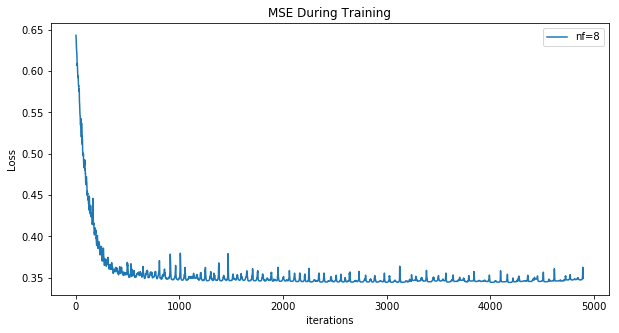

In [12]:
plt.figure(figsize=(10, 5))
plt.title("MSE During Training")
plt.plot(trainloss[100:], label="nf={}".format(nf))
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.show()
plt.savefig('AE_TRAINING.png')

# Alter feature dimension

# Save Model

In [13]:
PATH = './AE_NET.pth'
torch.save(net.state_dict(), PATH)

# Testing

In [14]:
X_test, Y_test = next(iter(testloader))
X_test, Y_test = X_train, Y_train

X_test = X_test.view(-1, 1, X_test.shape[-2], X_test.shape[-1])
Y_test = Y_test.view(-1, 1, Y_test.shape[-2], Y_test.shape[-1])

if GPU:
    X_test = Variable(X_test).cuda()
    Y_pred = net(X_test)

In [15]:
Y_test.shape

torch.Size([240, 1, 32, 32])

In [16]:
Y_pred.shape

torch.Size([240, 1, 32, 32])

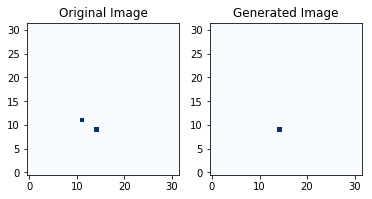

In [41]:
num = 166
fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(Y_test[num, 0, :, :].cpu(), origin='lower', cmap='Blues')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(Y_pred[num, 0, :, :].cpu().detach(), origin='lower', cmap='Blues')

plt.savefig('AE_{}.png'.format(num))
plt.show()

# Encoder Weights Visualization

In [23]:
trained_weights = copy.deepcopy(net.decoder[3].weight.data)
d_weights = init_weights - trained_weights

In [24]:
net.decoder[3]

ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [25]:
d_weights.shape

torch.Size([64, 32, 4, 4])

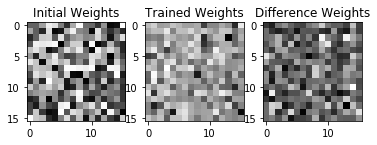

In [26]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')
plt.savefig('weights.png')